# Лабораторная работа №3

## 1. Реализовать HyperLogLog

In [ ]:
import hashlib
import math
import numpy as np
from matplotlib import pyplot as plt

class HyperLogLog:
    def __init__(self, b=4):
        self.b = b
        self.m = 1 << b  # количество регистров = 2^b
        self.registers = np.zeros(self.m, dtype=np.uint8)
        self.alpha = self._get_alpha()
        
    def _get_alpha(self):
        if self.m == 16:
            return 0.673
        elif self.m == 32:
            return 0.697
        elif self.m == 64:
            return 0.709
        else:
            return 0.7213 / (1 + 1.079 / self.m)
    
    def _hash(self, value):
        hash_obj = hashlib.sha1(str(value).encode('utf-8'))
        hash_hex = hash_obj.hexdigest()
        hash_int = int(hash_hex, 16)
        
        # Берём ПЕРВЫЕ b бит хеша для индекса регистра
        index = hash_int >> (160 - self.b)
        
        # Остаток хеша (все биты кроме первых b)
        remaining = hash_int & ((1 << (160 - self.b)) - 1)
        
        if remaining == 0:
            return index, 64 
        
        # Находим позицию первой 1 в бинарном представлении
        leading_zeros = (160 - self.b) - remaining.bit_length()
        first_one = leading_zeros + 1
        
        return index, first_one
        
    def add(self, value):
        index, first_one = self._hash(value)
        if first_one > self.registers[index]:
            self.registers[index] = first_one
    
    def count(self):
        harmonic_mean = np.sum(2.0 ** -self.registers)
        estimate = self.alpha * self.m * self.m / harmonic_mean
        
        # Коррекции для малых и больших значений
        if estimate <= 2.5 * self.m:
            # Коррекция для малых оценок
            zeros = np.sum(self.registers == 0)
            if zeros != 0:
                estimate = self.m * math.log(self.m / zeros)
        elif estimate > (1 << 160) / 30.0:
            # Коррекция для очень больших оценок
            estimate = -(1 << 160) * math.log(1.0 - estimate / (1 << 160))
        
        return estimate

## 2. Определить процент ложноположительных срабатываний конкретной реализации.

In [26]:
import random
import string

def generate_random_string(length=10):
    return ''.join(random.choices(string.ascii_letters + string.digits, k=length))

def calculate_false_positive_rate(b, num_elements=10000, num_tests=100):
    false_positives = 0
    total_checks = 0
    
    for _ in range(num_tests):
        # Генерируем два непересекающихся набора случайных данных
        added_elements = {generate_random_string() for _ in range(num_elements)}
        test_elements = set()
        while len(test_elements) < num_elements:
            new_element = generate_random_string()
            if new_element not in added_elements:
                test_elements.add(new_element)
        
        # Добавляем первый набор в HLL
        hll = HyperLogLog(b)
        for element in added_elements:
            hll.add(element)
        
        # Проверяем элементы из второго набора
        for element in test_elements:
            before = hll.count()
            hll.add(element)
            after = hll.count()
            
            # Считаем ложноположительным, если оценка не изменилась
            if abs(after - before) < 1e-6:
                false_positives += 1
            total_checks += 1
    
    return (false_positives / total_checks) * 100 if total_checks > 0 else 0

## 3. Оценить зависимость ложноположительных срабатываний от гиперпараметров алгоритма (таблица и графики зависимостей).

Testing b=4...
b=4, False positive rate: 100.0000%
Testing b=5...
b=5, False positive rate: 100.0000%
Testing b=6...
b=6, False positive rate: 100.0000%
Testing b=7...
b=7, False positive rate: 99.9970%
Testing b=8...
b=8, False positive rate: 99.4930%
Testing b=9...
b=9, False positive rate: 93.7390%
Testing b=10...
b=10, False positive rate: 76.0280%
Testing b=11...
b=11, False positive rate: 51.4630%
Testing b=12...
b=12, False positive rate: 30.8470%
Testing b=13...
b=13, False positive rate: 16.7930%
Testing b=14...
b=14, False positive rate: 8.7130%
Testing b=15...
b=15, False positive rate: 4.5230%
Testing b=16...
b=16, False positive rate: 2.2580%


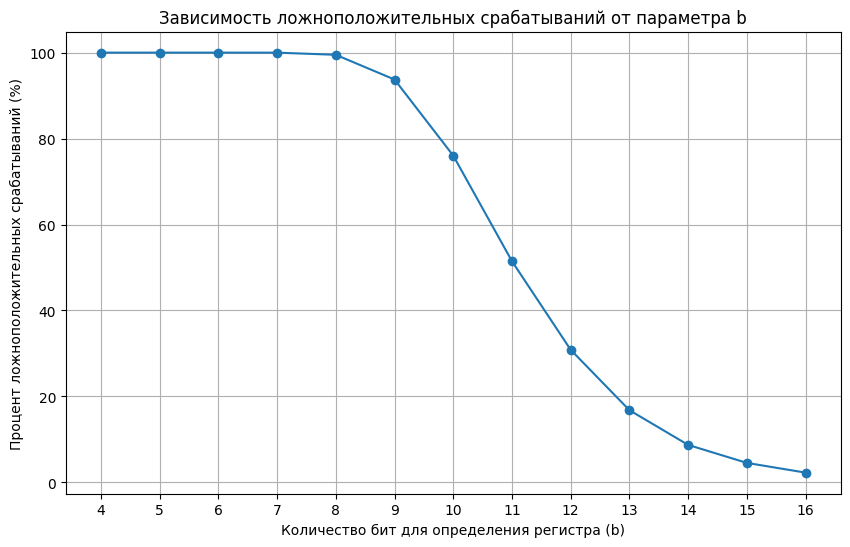


Таблица зависимости:
b	False Positive Rate (%)
4	100.0000
5	100.0000
6	100.0000
7	99.9970
8	99.4930
9	93.7390
10	76.0280
11	51.4630
12	30.8470
13	16.7930
14	8.7130
15	4.5230
16	2.2580


In [ ]:
def analyze_false_positive_rates():
    b_values = range(4, 17)  # от 4 до 16 бит
    fp_rates = []
    
    for b in b_values:
        print(f"Testing b={b}...")
        fp_rate = calculate_false_positive_rate(b, num_elements=1000, num_tests=100)
        fp_rates.append(fp_rate)
        print(f"b={b}, False positive rate: {fp_rate:.4f}%")
    
    plt.figure(figsize=(10, 6))
    plt.plot(b_values, fp_rates, marker='o')
    plt.title('Зависимость ложноположительных срабатываний от параметра b')
    plt.xlabel('Количество бит для определения регистра (b)')
    plt.ylabel('Процент ложноположительных срабатываний (%)')
    plt.grid(True)
    plt.xticks(b_values)
    plt.show()
    
    print("\nТаблица зависимости:")
    print("b\tFalse Positive Rate (%)")
    for b, rate in zip(b_values, fp_rates):
        print(f"{b}\t{rate:.4f}")

analyze_false_positive_rates()